In [1]:
from dsc4ml.encoders import LocalEncoder, DistributedEncoder
from dsc4ml.decoders import FusionDecoder
import xarray as xr
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'Dark2'

DA = xr.DataArray

def generate_2d_dataset(n, ρ=0.0, sep=0.0):
    μ = [1, 0]
    Σ = [[1, ρ],
         [ρ, 1]]
    w = make_normal_unit_vector(2)
    X = DA(npr.multivariate_normal(μ, Σ, size=n), dims=['n', 'd'])
    y = np.sign(X @ w)
    X += sep*y*w
    return X, y


def sample(A, dim, size):
    i_sample = npr.randint(A[dim].size, size=size)
    return A[i_sample]


def calc_total_loss(γ):
    def curry(A, B):
        w = make_normal_unit_vector(A.sizes['d'])
        mse = calc_mse_loss(A, B)
        zero_one = calc_zero_one_loss(A, B)
        return (1-γ)*mse + γ*zero_one
    return curry


def calc_zero_one_loss(A, B):
    return np.sign(A @ w) != np.sign(B @ w)


def calc_mse_loss(A, B):
    return np.power(A - B, 2).sum('d')


def make_normal_unit_vector(d) -> '(d,)':
    w = np.append(-1, np.ones(d-1))
    w = w/np.sqrt(w @ w)
    return xr.DataArray(w, dims='d')


def plot_decision_boundary(X):
    p = [X.min(), X.max()]
    plt.plot(p, p, '--', alpha=0.25)


w = make_normal_unit_vector(2)

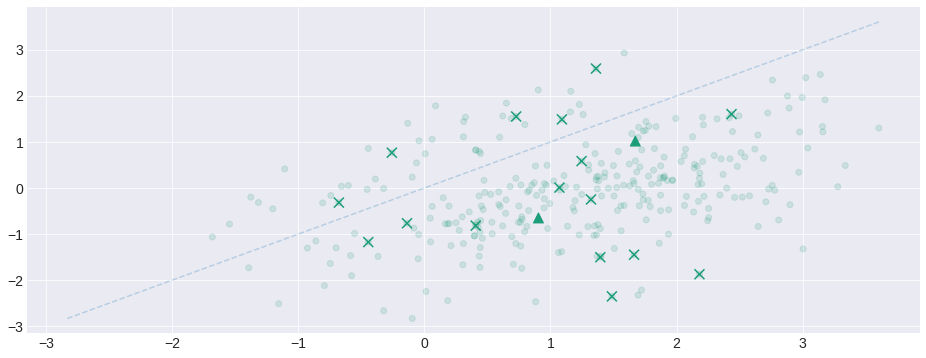

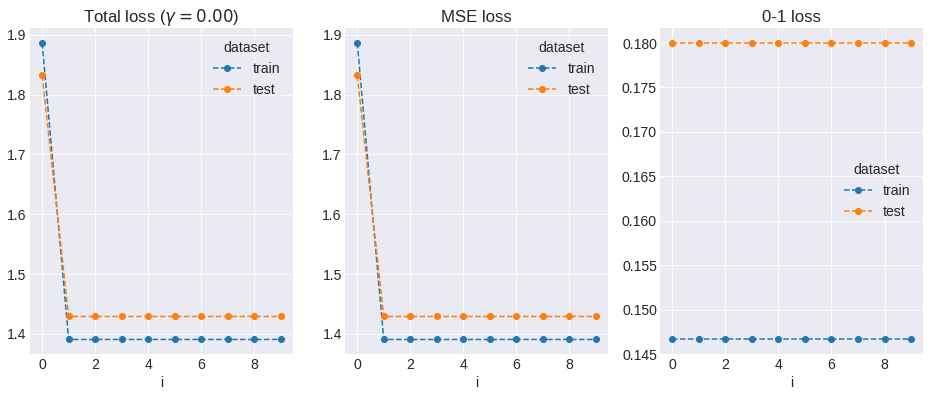

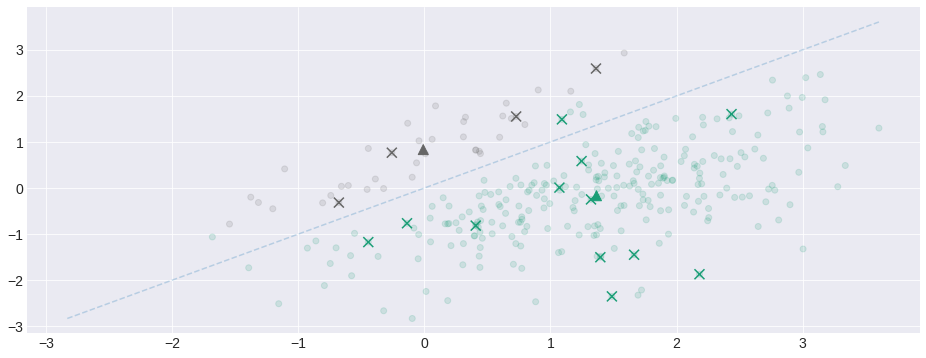

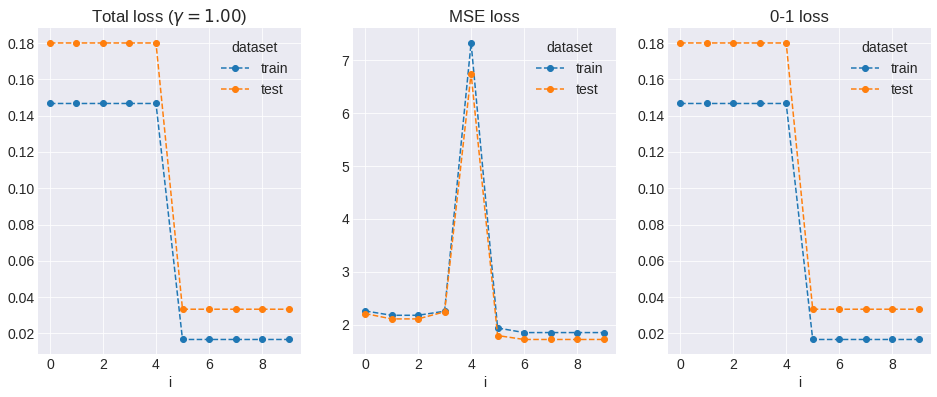

In [2]:
for γ in [0, 1]:
    npr.seed(0)

    ρ = 0.5
    sep = 0.2

    p = 16
    X, _ = generate_2d_dataset(300, ρ, sep)
    protos = sample(X, 'n', p).rename(n='p')
    q_indices = DA(npr.randint(2, size=p), dims='p')
    codebook = sample(X, 'n', 2).rename(n='m')

    enc = LocalEncoder(protos, q_indices, rate=2)
    dec = FusionDecoder(codebook)

    losses = list()
    Z, _ = generate_2d_dataset(300, ρ, sep)
    for i in range(10):
        dec = dec.optimize(X, enc, γ, w)
        enc = enc.optimize(X, dec, calc_total_loss(γ))

        losses += [
            {'dataset': 'train',
             'loss_type': 'total',
             'value': calc_total_loss(γ)(X, dec(enc(X))).mean().item(),
             'i': i},

            {'dataset': 'test',
             'loss_type': 'total',
             'value': calc_total_loss(γ)(Z, dec(enc(Z))).mean().item(),
             'i': i},

            {'dataset': 'train',
             'loss_type': 'mse',
             'value': calc_mse_loss(X, dec(enc(X))).mean().item(),
             'i': i},

            {'dataset': 'test',
             'loss_type': 'mse',
             'value': calc_mse_loss(Z, dec(enc(Z))).mean().item(),
             'i': i},

            {'dataset': 'train',
             'loss_type': 'zero_one',
             'value': calc_zero_one_loss(X, dec(enc(X))).mean().item(),
             'i': i},

            {'dataset': 'test',
             'loss_type': 'zero_one',
             'value': calc_zero_one_loss(Z, dec(enc(Z))).mean().item(),
             'i': i},
        ]

    losses = (pd.DataFrame(losses)
                .pivot('i', ['loss_type', 'dataset'], 'value'))

    plt.scatter(*enc.protos.T, c=np.sign(dec(enc(enc.protos.rename(p='n'))) @ w), marker='x', s=100)
    plt.scatter(*dec.codebook.T, c=np.sign(dec.codebook @ w), marker='^', s=100)
    plt.scatter(*X.T, c=np.sign(dec(enc(X)) @ w), alpha=0.15)
    plot_decision_boundary(X)
    plt.show()

    (losses['total']
     .plot(style='o--',
           ax=plt.subplot(1, 3, 1),
           title=f'Total loss ($\gamma = {γ:.2f}$)'))
    (losses['mse']
     .plot(style='o--',
           ax=plt.subplot(1, 3, 2),
           title='MSE loss'))
    (losses['zero_one']
     .plot(style='o--',
           ax=plt.subplot(1, 3, 3),
           title='0-1 loss'))

    plt.show()

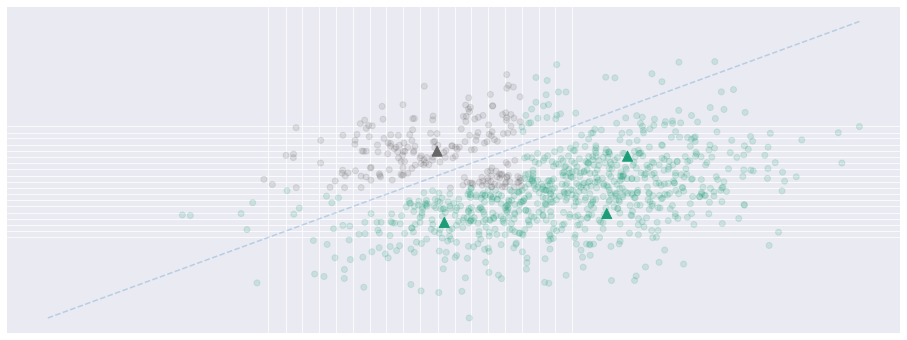

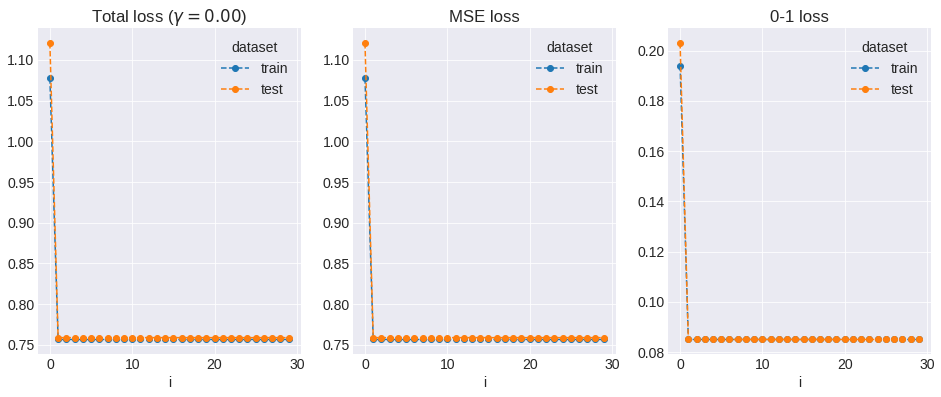

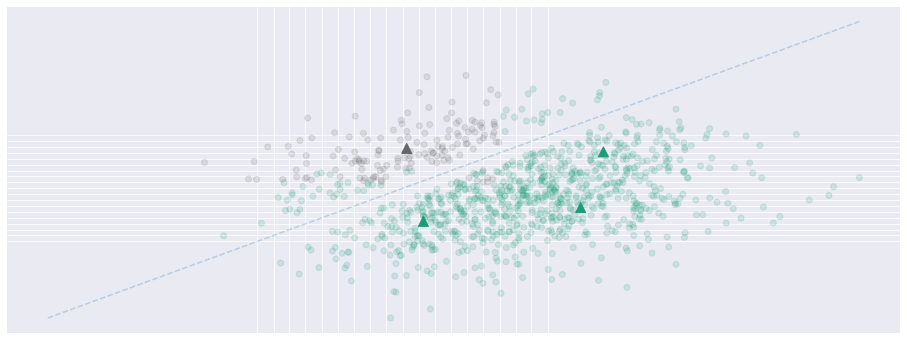

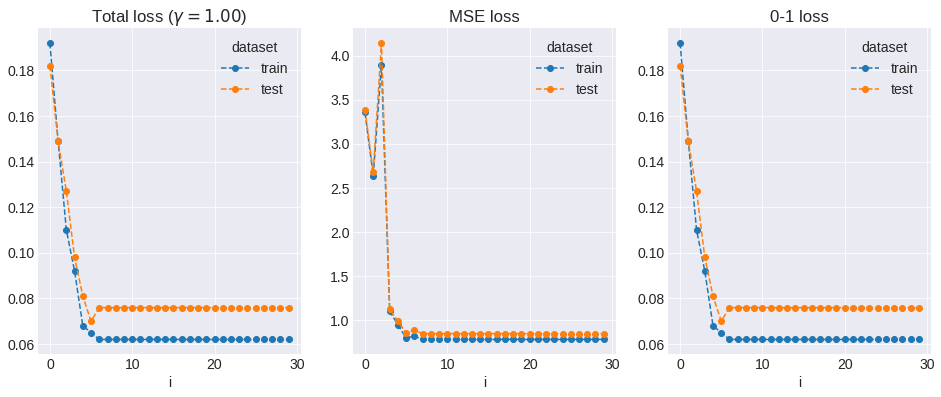

In [3]:
npr.seed(0)
for γ in [0, 1]:

    # Untreated corner cases (both will break the code):
    # - If p is too large, there will be proto-regions without points.
    # - If rate_exp is too large, some integer will be proto-region-less
    p = [20, 20]
    rate_exp = [2, 2]

    ρ = 0.3
    sep = 0.2

    X, _ = generate_2d_dataset(1_000, ρ, sep)
    encoders = [
        LocalEncoder(DA(np.linspace(-1.5, 1.5, p[0]), dims='p').expand_dims(d=1),
                     DA(npr.randint(rate_exp[0], size=p[0]), dims='p'),
                     rate_exp[0]),

        LocalEncoder(DA(np.linspace(-1.5, 1.5, p[1]), dims='p').expand_dims(d=1),
                     DA(npr.randint(rate_exp[1], size=p[1]), dims='p'),
                     rate_exp[1])
    ]

    enc = DistributedEncoder(encoders)
    dec = FusionDecoder.init_from_encoder(X, enc, γ, w)

    losses = list()
    Z, _ = generate_2d_dataset(1_000, ρ, sep)
    for i in range(30):
        dec = dec.optimize(X, enc, γ, w)
        enc = enc.optimize(X, dec, calc_total_loss(γ))

        losses += [
            {'dataset': 'train',
             'loss_type': 'total',
             'value': calc_total_loss(γ)(X, dec(enc(X))).mean().item(),
             'i': i},

            {'dataset': 'test',
             'loss_type': 'total',
             'value': calc_total_loss(γ)(Z, dec(enc(Z))).mean().item(),
             'i': i},

            {'dataset': 'train',
             'loss_type': 'mse',
             'value': calc_mse_loss(X, dec(enc(X))).mean().item(),
             'i': i},

            {'dataset': 'test',
             'loss_type': 'mse',
             'value': calc_mse_loss(Z, dec(enc(Z))).mean().item(),
             'i': i},

            {'dataset': 'train',
             'loss_type': 'zero_one',
             'value': calc_zero_one_loss(X, dec(enc(X))).mean().item(),
             'i': i},

            {'dataset': 'test',
             'loss_type': 'zero_one',
             'value': calc_zero_one_loss(Z, dec(enc(Z))).mean().item(),
             'i': i},
        ]

    losses = (pd.DataFrame(losses)
                .pivot('i', ['loss_type', 'dataset'], 'value'))

    plt.scatter(*dec.codebook.T, c=np.sign(dec.codebook @ w), marker='^', s=100)
    plt.scatter(*X.T, c=np.sign(dec(enc(X)) @ w), alpha=0.15)
    plt.xticks(enc[0].boundaries.round(2), '')
    plt.yticks(enc[1].boundaries.round(2), '')
    plot_decision_boundary(X)
    plt.show()

    (losses['total']
     .plot(style='o--',
           ax=plt.subplot(1, 3, 1),
           title=f'Total loss ($\gamma = {γ:.2f}$)'))
    (losses['mse']
     .plot(style='o--',
           ax=plt.subplot(1, 3, 2),
           title='MSE loss'))
    (losses['zero_one']
     .plot(style='o--',
           ax=plt.subplot(1, 3, 3),
           title='0-1 loss'))

    plt.show()

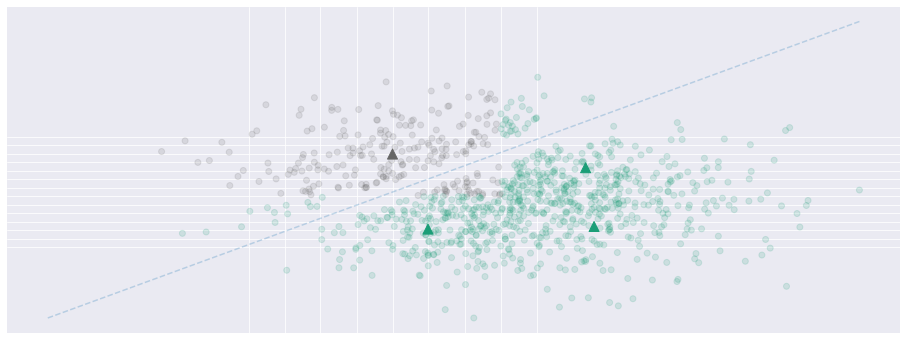

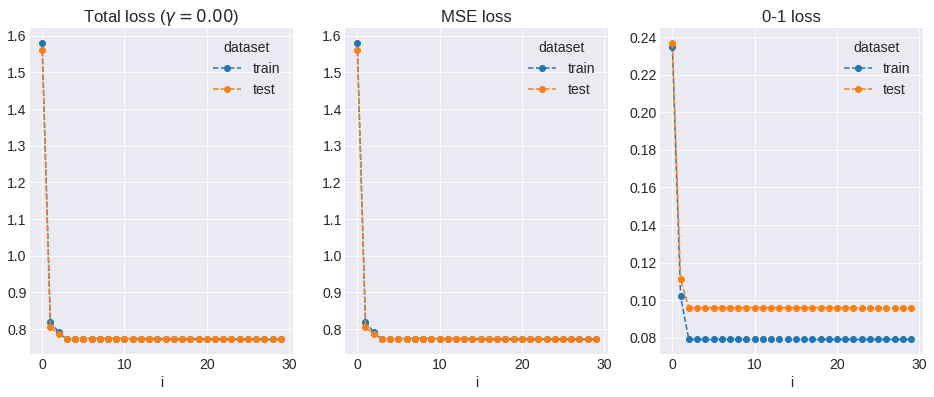

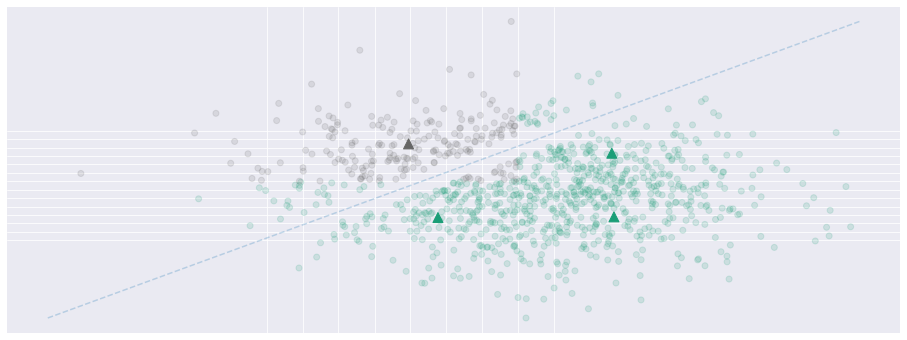

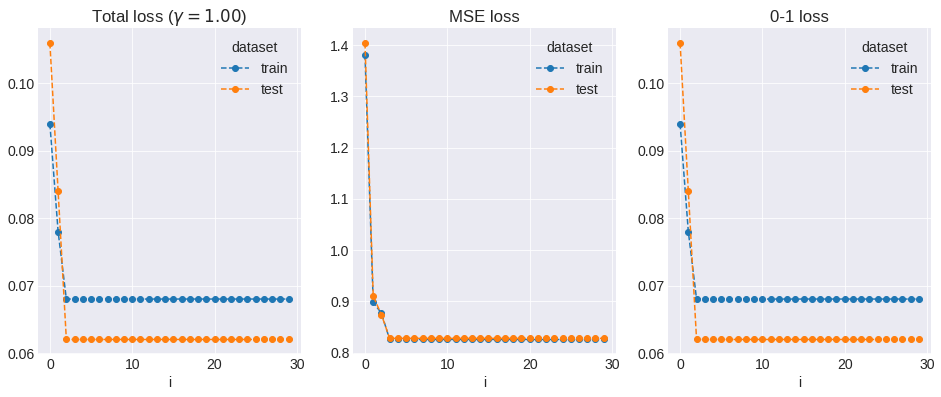

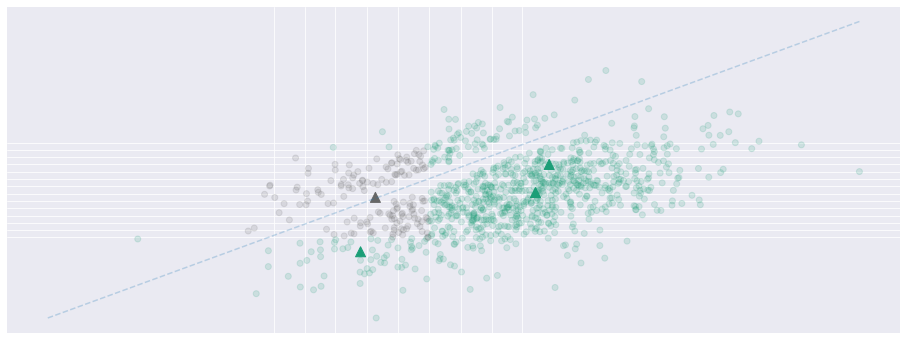

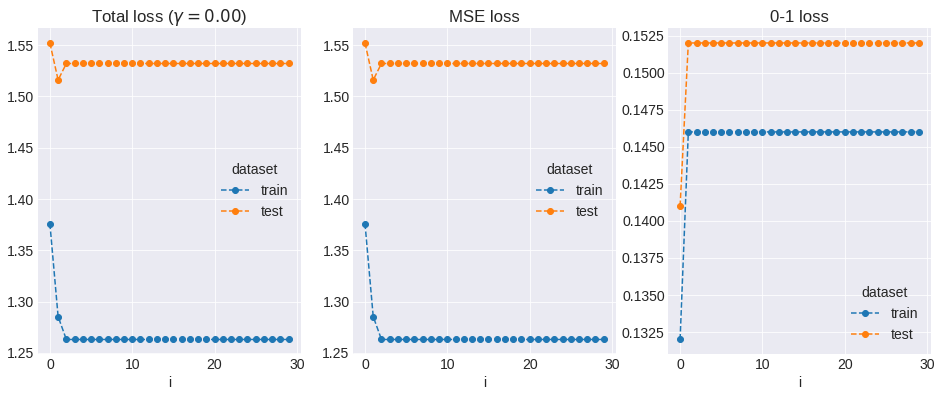

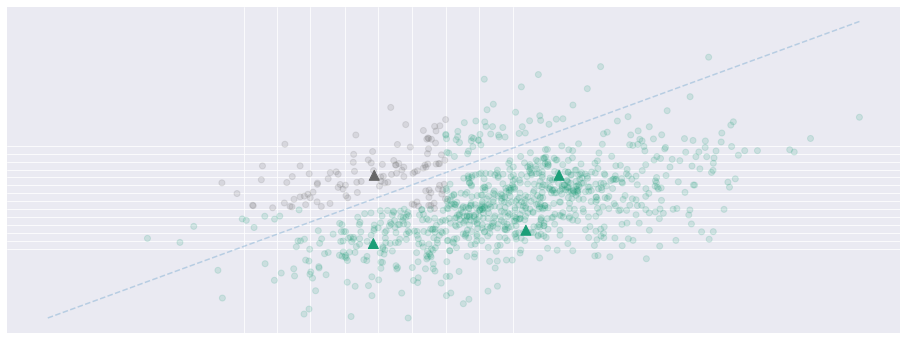

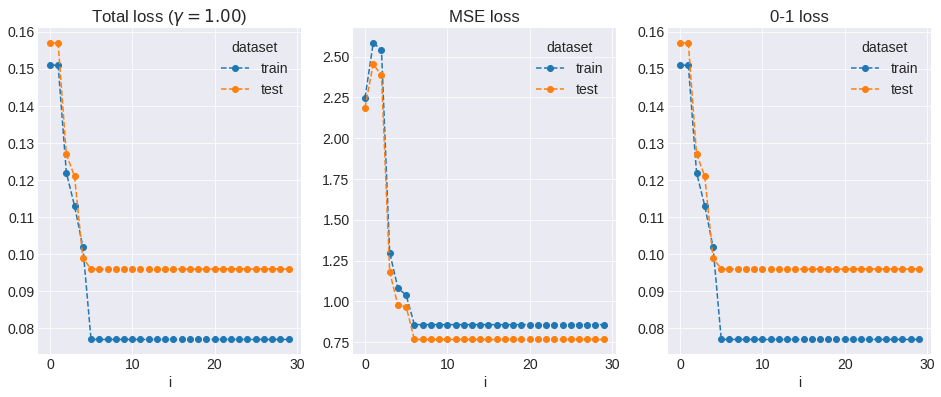

In [4]:
npr.seed(0)
for ρ in [0, 0.5]:
    for γ in [0, 1]:

        # Untreated corner cases (both will break the code):
        # - If p is too large, there will be proto-regions without points.
        # - If rate_exp is too large, some integer will be proto-region-less
        p = [10, 15]
        rate_exp = [2, 2]

        sep = 0.2

        X, _ = generate_2d_dataset(1_000, ρ, sep)
        encoders = [
            LocalEncoder(DA(np.linspace(-1.5, 1.5, p[0]), dims='p').expand_dims(d=1),
                         DA(npr.randint(rate_exp[0], size=p[0]), dims='p'),
                         rate_exp[0]),

            LocalEncoder(DA(np.linspace(-1.5, 1.5, p[1]), dims='p').expand_dims(d=1),
                         DA(npr.randint(rate_exp[1], size=p[1]), dims='p'),
                         rate_exp[1])
        ]

        enc = DistributedEncoder(encoders)
        dec = FusionDecoder.init_from_encoder(X, enc, γ, w)

        losses = list()
        Z, _ = generate_2d_dataset(1_000, ρ, sep)
        for i in range(30):
            dec = dec.optimize(X, enc, γ, w)
            enc = enc.optimize(X, dec, calc_total_loss(γ))

            losses += [
                {'dataset': 'train',
                 'loss_type': 'total',
                 'value': calc_total_loss(γ)(X, dec(enc(X))).mean().item(),
                 'i': i,
                 'ρ': ρ,
                 'γ': γ},

                {'dataset': 'test',
                 'loss_type': 'total',
                 'value': calc_total_loss(γ)(Z, dec(enc(Z))).mean().item(),
                 'i': i,
                 'ρ': ρ,
                 'γ': γ},

                {'dataset': 'train',
                 'loss_type': 'mse',
                 'value': calc_mse_loss(X, dec(enc(X))).mean().item(),
                 'i': i,
                 'ρ': ρ,
                 'γ': γ},

                {'dataset': 'test',
                 'loss_type': 'mse',
                 'value': calc_mse_loss(Z, dec(enc(Z))).mean().item(),
                 'i': i,
                 'ρ': ρ,
                 'γ': γ},

                {'dataset': 'train',
                 'loss_type': 'zero_one',
                 'value': calc_zero_one_loss(X, dec(enc(X))).mean().item(),
                 'i': i,
                 'ρ': ρ,
                 'γ': γ},

                {'dataset': 'test',
                 'loss_type': 'zero_one',
                 'value': calc_zero_one_loss(Z, dec(enc(Z))).mean().item(),
                 'i': i,
                 'ρ': ρ,
                 'γ': γ},
            ]

        losses = (pd.DataFrame(losses)
                    .pivot('i', ['loss_type', 'dataset'], 'value'))

        plt.scatter(*dec.codebook.T, c=np.sign(dec.codebook @ w), marker='^', s=100)
        plt.scatter(*X.T, c=np.sign(dec(enc(X)) @ w), alpha=0.15)
        plt.xticks(enc[0].boundaries.round(2), '')
        plt.yticks(enc[1].boundaries.round(2), '')
        plot_decision_boundary(X)
        plt.show()

        (losses['total']
         .plot(style='o--',
               ax=plt.subplot(1, 3, 1),
               title=f'Total loss ($\gamma = {γ:.2f}$)'))
        (losses['mse']
         .plot(style='o--',
               ax=plt.subplot(1, 3, 2),
               title='MSE loss'))
        (losses['zero_one']
         .plot(style='o--',
               ax=plt.subplot(1, 3, 3),
               title='0-1 loss'))

        plt.show()